# Language Modeling Sequential


Let's try the language modeling task by using chariot and PyTorch.
When using PyTorch, we use sequential type data feeding.

* Download the WikiText2 dataset by chazutsu.
* Preprocess WikiText2 by chariot.
* Make model by PyTorch.
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* PyTorch
* matplotlib


## Prepare the packages

In [55]:
import os
import sys
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [58]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.data_path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [59]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [60]:
import chariot.transformer as ct
from chariot.preprocessor import Preprocessor


lm_processor = Preprocessor(
                    text_transformers=[
                        ct.text.UnicodeNormalizer(),
                        ct.text.LowerNormalizer()
                    ],
                    tokenizer=ct.Tokenizer(lang=None),
                    vocabulary=ct.Vocabulary(min_df=5))

preprocessed = lm_processor.fit_transform(r.valid_data())

In [61]:
print(len(lm_processor.vocabulary.get()))

4321


## Make model by PyTorch

In [62]:
import torch
import torch.nn as nn


class LanguageModel(nn.Module):

    def __init__(self, ntoken, ninp, nhid, dropout=0.5):
        super(LanguageModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()
        self.nhid = nhid
        self.nlayers = 1

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

In [63]:
vocab_size = lm_processor.vocabulary.count
embedding_size = 100
hidden_size = 100


model = LanguageModel(vocab_size, embedding_size, hidden_size)

c:\users\ico\documents\works\chariot\venv\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Train the Model

In [64]:
from chariot.feeder import LanguageModelFeeder


train_feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})
test_feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})

In [72]:
batch_size=20
sequence_length=35
criterion = nn.CrossEntropyLoss()
preprocessed_test = lm_processor.transform(r.test_data())


def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


def evaluate():
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(batch_size)
    iteration = 0
    with torch.no_grad():
        for data, targets in test_feeder.iterate(preprocessed_test, batch_size=batch_size,
                                                 sequence_length=sequence_length, epoch=1):

            data = torch.from_numpy(data).type(torch.LongTensor)
            targets = torch.from_numpy(targets).type(torch.LongTensor).contiguous().view(-1,)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, vocab_size)
            total_loss += criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
            iteration += 1
    return total_loss / iteration

In [73]:
model.train()
state = model.init_hidden(batch_size)
optimizer = torch.optim.Adam(model.parameters())


steps_per_epoch, _ = train_feeder.make_generator(preprocessed, batch_size=batch_size,
                                                 sequence_length=sequence_length)

total_loss = 0
step_count = 0
epoch = 1
hidden = model.init_hidden(batch_size)
history = []

for data, targets in train_feeder.iterate(preprocessed, batch_size=batch_size,
                                          sequence_length=sequence_length, epoch=10):
    
    data = torch.from_numpy(data).type(torch.LongTensor)
    targets = torch.from_numpy(targets).type(torch.LongTensor).contiguous().view(-1,)
    optimizer.zero_grad()
    hidden = repackage_hidden(hidden)
    output, hidden = model(data, hidden)
    loss = criterion(output.view(-1, vocab_size), targets)    
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    step_count += 1
    
    if step_count % steps_per_epoch == 0:
        _loss = total_loss / steps_per_epoch
        test_loss = evaluate()
        metrics = {
            "loss": _loss,
            "perplexity": math.exp(_loss),
            "val_loss": test_loss,
            "val_perplexity": math.exp(test_loss)            
        }
        history.append(metrics)
        print("Epoch {}: loss={}, perplexity={} val_loss={}, val_perplexity={}.".format(
            epoch, metrics["loss"], metrics["perplexity"], metrics["val_loss"], metrics["val_perplexity"] ))
        epoch += 1
        total_loss = 0
        step_count = 0

Epoch 1: loss=4.969565869941086, perplexity=143.96437454015125 val_loss=4.479169684787129, val_perplexity=88.16144049173171.
Epoch 2: loss=4.787716432477607, perplexity=120.02696579282178 val_loss=4.439061253569847, val_perplexity=84.69539684202022.
Epoch 3: loss=4.696833125880508, perplexity=109.59953435076773 val_loss=4.389513349810312, val_perplexity=80.60118485270583.
Epoch 4: loss=4.601015872642642, perplexity=99.58543038772257 val_loss=4.342218850241151, val_perplexity=76.87793084716745.
Epoch 5: loss=4.491852930725598, perplexity=89.28673483123507 val_loss=4.292194751806037, val_perplexity=73.1267876541756.
Epoch 6: loss=4.390822469211016, perplexity=80.7067705245626 val_loss=4.253174366646035, val_perplexity=70.32830621561153.
Epoch 7: loss=4.297502508319792, perplexity=73.51595873669854 val_loss=4.216587772896124, val_perplexity=67.8017342071733.
Epoch 8: loss=4.207295439673252, perplexity=67.17461610750568 val_loss=4.175643721985263, val_perplexity=65.08172071415585.
Epoch 9:

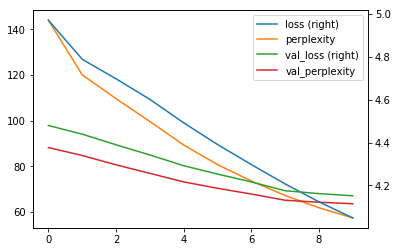

In [74]:
pd.DataFrame(history).plot.line(secondary_y=["loss", "val_loss"])